Columns

Each row in the file corresponds to a single player's involvement in a single play. The dataset was intentionally joined (i.e. denormalized) to make the API simple. All the columns are contained in one large dataframe which is grouped and provided by PlayId.

- GameId - a unique game identifier
- PlayId - a unique play identifier
- Team - home or away
- X - player position along the long axis of the field. See figure below.
- Y - player position along the short axis of the field. See figure below.
- S - speed in yards/second
- A - acceleration in yards/second^2
- Dis - distance traveled from prior time point, in yards
    -  Dis measures time covered in the most recent window of player tracking data. Given that tracking data roughly covers 10 frames per second, Dis corresponds to distance traveled in the recent 0.1 seconds. Note that speed and acceleration are directly calculated using Dis (this is done in the data pre-processing)
- Orientation - orientation of player (deg)
- Dir - angle of player motion (deg)
- NflId - a unique identifier of the player
- DisplayName - player's name
- JerseyNumber - jersey number
- Season - year of the season
- YardLine - the yard line of the line of scrimmage
- Quarter - game quarter (1-5, 5 == overtime)
- GameClock - time on the game clock
- PossessionTeam - team with possession
- Down - the down (1-4)
- Distance - yards needed for a first down
- FieldPosition - which side of the field the play is happening on
- HomeScoreBeforePlay - home team score before play started
- VisitorScoreBeforePlay - visitor team score before play started
- NflIdRusher - the NflId of the rushing player
- OffenseFormation - offense formation
- OffensePersonnel - offensive team positional grouping
- DefendersInTheBox - number of defenders lined up near the line of scrimmage, spanning the width of the offensive line
- DefensePersonnel - defensive team positional grouping
- PlayDirection - direction the play is headed
- TimeHandoff - UTC time of the handoff
- TimeSnap - UTC time of the snap
- Yards - the yardage gained on the play (you are predicting this)
- PlayerHeight - player height (ft-in)
- PlayerWeight - player weight (lbs)
- PlayerBirthDate - birth date (mm/dd/yyyy)
- PlayerCollegeName - where the player attended college
- Position - the player's position (the specific role on the field that they typically play)
- HomeTeamAbbr - home team abbreviation
- VisitorTeamAbbr - visitor team abbreviation
- Week - week into the season
- Stadium - stadium where the game is being played
- Location - city where the game is being player
- StadiumType - description of the stadium environment
- Turf - description of the field surface
- GameWeather - description of the game weather
- Temperature - temperature (deg F)
- Humidity - humidity
- WindSpeed - wind speed in miles/hour
- WindDirection - wind direction

https://www.kaggle.com/c/nfl-big-data-bowl-2020/data

In [7]:
import pip #needed to use the pip functions

In [9]:
for i in pip.get_installed_distributions(local_only=True):
    print(i)

AttributeError: module 'pip' has no attribute 'get_installed_distributions'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
import matplotlib.patches as patches
from draw_football_field import create_football_field
import seaborn as sns
import datetime, tqdm
from string import punctuation
import re
import math

pd.set_option('display.max_columns', 500)

In [2]:
def emptyLine(numlines=1):
    print('*'*60*numlines)

In [3]:
# Load data
train = pd.read_csv('train.csv')

# From https://www.kaggle.com/cpmpml/initial-wrangling-voronoi-areas-in-python
train.loc[train.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
train.loc[train.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"

train.loc[train.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
train.loc[train.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"

train.loc[train.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
train.loc[train.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"

train.loc[train.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
train.loc[train.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"

train['ToLeft'] = train.PlayDirection == "left"
train['Dir_rad'] = np.mod(90 - train.Dir, 360) * math.pi/180.0
# train['Orientation_rad'] = np.mod(90 - train.Orientation, 360) * math.pi/180.0

train['IsBallCarrier'] = train.NflId == train.NflIdRusher

/Users/dalpengholic/anaconda3/envs/nbastat1/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Exploration

count    509762.000000
mean          4.212334
std           6.436167
min         -14.000000
0.3%         -6.000000
5%           -2.000000
25%           1.000000
50%           3.000000
75%           6.000000
95%          14.000000
99.7%        50.000000
max          99.000000
Name: Yards, dtype: float64


/Users/dalpengholic/anaconda3/envs/nbastat1/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/dalpengholic/anaconda3/envs/nbastat1/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


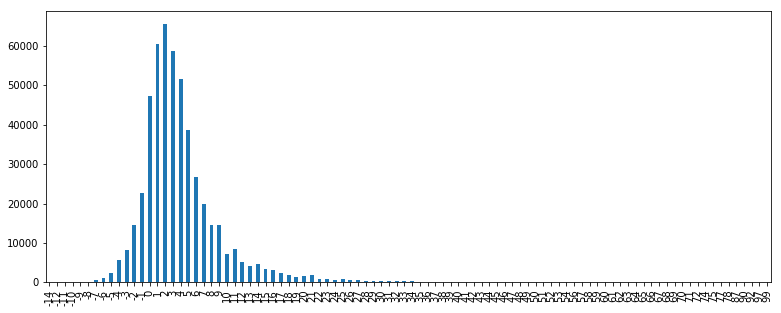

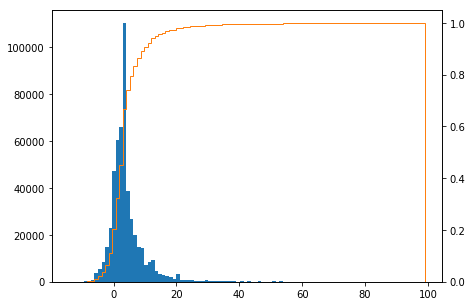

In [4]:
# Result of handsoff
print(train.Yards.describe(percentiles=[0.003, 0.05, 0.25, 0.95, 0.75, 0.997]))
train.Yards.value_counts().sort_index().plot(kind='bar',figsize=(13,5),rot=90)

series =train.Yards
fig, ax = plt.subplots(figsize=(7,5))
ax2 = ax.twinx()
n, bins, patches = ax.hist(series, bins=100, normed=False)
n, bins, patches = ax2.hist(series, cumulative=1, histtype='step', bins=100, color='tab:orange',  normed=True)

In [5]:
# Check empty cells in each column
print("Shape of dataframe: ",train.shape); emptyLine()
print("Num of unique GameId: ",len(train.GameId.unique().tolist())); emptyLine()
print(train.columns[train.isna().any()].tolist()); emptyLine()
print("Max of TimeHandoff", train.TimeHandoff.max())
print("Min of TimeHandoff", train.TimeHandoff.min())
train.isna().sum()

Shape of dataframe:  (509762, 52)
************************************************************
Num of unique GameId:  512
************************************************************
['Orientation', 'Dir', 'FieldPosition', 'OffenseFormation', 'DefendersInTheBox', 'StadiumType', 'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Dir_rad']
************************************************************
Max of TimeHandoff 2018-12-31T04:18:19.000Z
Min of TimeHandoff 2017-09-08T00:44:06.000Z


GameId                        0
PlayId                        0
Team                          0
X                             0
Y                             0
S                             0
A                             0
Dis                           0
Orientation                  18
Dir                          14
NflId                         0
DisplayName                   0
JerseyNumber                  0
Season                        0
YardLine                      0
Quarter                       0
GameClock                     0
PossessionTeam                0
Down                          0
Distance                      0
FieldPosition              6424
HomeScoreBeforePlay           0
VisitorScoreBeforePlay        0
NflIdRusher                   0
OffenseFormation            110
OffensePersonnel              0
DefendersInTheBox            66
DefensePersonnel              0
PlayDirection                 0
TimeHandoff                   0
TimeSnap                      0
Yards   

In [6]:
cat_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append((col, len(train[col].unique())))
        
cat_features

[('Team', 2),
 ('DisplayName', 2230),
 ('GameClock', 901),
 ('PossessionTeam', 32),
 ('FieldPosition', 33),
 ('OffenseFormation', 9),
 ('OffensePersonnel', 56),
 ('DefensePersonnel', 38),
 ('PlayDirection', 2),
 ('TimeHandoff', 22935),
 ('TimeSnap', 22943),
 ('PlayerHeight', 16),
 ('PlayerBirthDate', 1688),
 ('PlayerCollegeName', 301),
 ('Position', 25),
 ('HomeTeamAbbr', 32),
 ('VisitorTeamAbbr', 32),
 ('Stadium', 55),
 ('Location', 60),
 ('StadiumType', 30),
 ('Turf', 20),
 ('GameWeather', 62),
 ('WindSpeed', 59),
 ('WindDirection', 54)]

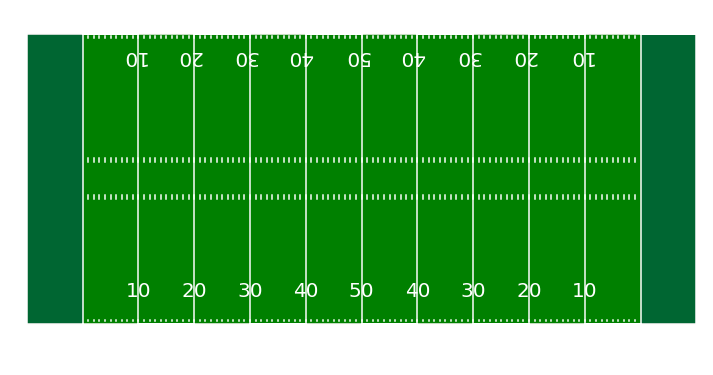

In [7]:
# Draw football field
# From https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position
create_football_field()
plt.show()

In [8]:
# fig, ax = create_football_field()
# train.query("PlayId == 20170907000118 and Team == 'away'") \
#     .plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=30, legend='Away')
# train.query("PlayId == 20170907000118 and Team == 'home'") \
#     .plot(x='X', y='Y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
# plt.title('Play # 20170907000118')
# plt.legend()
# plt.show()

In [9]:
# playid = 20181230154157
# train.query("PlayId == @playid").head()
# yl = train.query("PlayId == @playid")['YardLine'].tolist()[0]
# fig, ax = create_football_field(highlight_line=True,
#                                 highlight_line_number=yl+54)
# train.query("PlayId == @playid and Team == 'away'") \
#     .plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=30, legend='Away')
# train.query("PlayId == @playid and Team == 'home'") \
#     .plot(x='X', y='Y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
# plt.title(f'Play # {playid}')
# plt.legend()
# plt.show()

In [10]:
def get_dx_dy(radian_angle, dist):
    dx = dist * math.cos(radian_angle)
    dy = dist * math.sin(radian_angle)
    return dx, dy

def show_play(play_id, train=train):
    df = train[train.PlayId == play_id]
    yl = df['YardLine'].tolist()[0]
    print(yl)
    fig, ax = create_football_field(highlight_line=True, highlight_line_number=yl+54)
    ax.scatter(df.X, df.Y, cmap='rainbow', c=~(df.Team == 'home'), s=30)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X, rusher_row.Y, color='black')
    yards_covered = rusher_row["Yards"].values[0]
    x = rusher_row["X"].values[0]
    y = rusher_row["Y"].values[0]
    rusher_dir = rusher_row["Dir_rad"].values[0]
    rusher_speed = rusher_row["S"].values[0]
    dx, dy = get_dx_dy(rusher_dir, rusher_speed)

    ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.3, color='black')
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}', fontsize=20)
    plt.legend()
    plt.show()

22


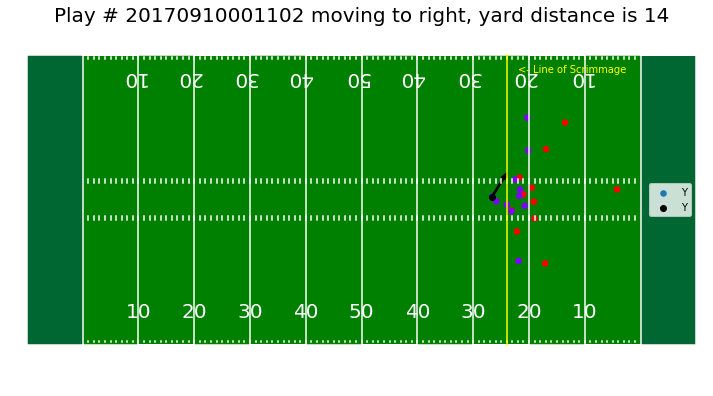

In [11]:
show_play(20170910001102)

## Feature Cleaning
### Stadium

In [12]:
%%time
# Stadium clean
# from https://www.kaggle.com/truenikita/neural-networks-multiple-output-stadium-clean
# 33 stadiums =  32 teams - 1 jets/giants share - 1rams/chargers share + wembley + twickenham + azteca.
# 34 stadiums = rams chargers don't share according to wiki

def func_clean_stadium():
    map_stad = {'Broncos Stadium at Mile High': 'Broncos Stadium At Mile High', \
            'CenturyField': 'CenturyLink Field', 'CenturyLink': 'CenturyLink Field', 'Everbank Field': 'TIAA Bank Field',\
            'FirstEnergy': 'First Energy Stadium', 'FirstEnergy Stadium': 'First Energy Stadium', \
            'FirstEnergyStadium': 'First Energy Stadium', 'Lambeau field': 'Lambeau Field', \
            'Los Angeles Memorial Coliesum': 'Los Angeles Memorial Coliseum', 'M & T Bank Stadium': 'M&T Bank Stadium',\
            'M&T Stadium': 'M&T Bank Stadium', 'Mercedes-Benz Dome': 'Mercedes-Benz Superdome',\
            'MetLife': 'MetLife Stadium', 'Metlife Stadium': 'MetLife Stadium', 'NRG': 'NRG Stadium',\
            'Oakland Alameda-County Coliseum': 'Oakland-Alameda County Coliseum', 'Paul Brown Stdium': 'Paul Brown Stadium',\
            'Twickenham': 'Twickenham Stadium', 'EverBank Field': 'TIAA Bank Field', \
            'Sports Authority Field at Mile High': 'Broncos Stadium At Mile High' ,'University of Phoenix Stadium':'State Farm Stadium'}

    for stad in train['Stadium'].unique():
        if stad in map_stad.keys():
            pass
        else:
            map_stad[stad]=stad

    train['Stadium'] = train['Stadium'].map(map_stad)
    
func_clean_stadium()
print("Number of Stadium: ", len(train.Stadium.unique()))
len(train.Stadium.unique())

Number of Stadium:  34
CPU times: user 121 ms, sys: 8.38 ms, total: 130 ms
Wall time: 131 ms


In [13]:
# Drop 'Location', which is redundant
train = train.drop('Location', axis=1)

### Turf (Grass_label : natural or not)

In [14]:
%%time
# Feature transformation: Turf 
# from https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/112681#latest-655119
def func_clean_turf():
    grass_labels = ['grass', 'natural grass', 'natural', 'naturall grass']
    train['NaturalGrass'] = np.where(train.Turf.str.lower().isin(grass_labels), 1, 0)

func_clean_turf()

CPU times: user 154 ms, sys: 19.8 ms, total: 174 ms
Wall time: 183 ms


In [15]:
# Drop 'Turf' column
train = train.drop('Turf', axis=1)
# Drop ''PlayerCollegeName" column
train = train.drop('PlayerCollegeName', axis=1)

## Feature extraction
### Age

In [16]:
%%time
def func_convert_to_datetime():
    train['PlayerBirthDate'] = pd.to_datetime(train['PlayerBirthDate'], infer_datetime_format=True)
    train['TimeSnap'] = pd.to_datetime(train['TimeSnap'], infer_datetime_format=True).dt.tz_convert(None)
    train['TimeHandoff'] = pd.to_datetime(train['TimeHandoff'], infer_datetime_format=True).dt.tz_convert(None)

func_convert_to_datetime()

CPU times: user 2.15 s, sys: 70.5 ms, total: 2.22 s
Wall time: 2.33 s


In [17]:
%%time
def func_get_player_age():
    '''
    Get player's age at the time the player played
    '''
    train['PlayerAge'] = train['TimeSnap'] - train['PlayerBirthDate']
    train['PlayerAge'] = train['PlayerAge'].apply(lambda x: (float(x.days)/365)).round(1)

func_get_player_age()    
train.head(2)

CPU times: user 6.18 s, sys: 218 ms, total: 6.4 s
Wall time: 6.76 s


In [18]:
# Drop 'PlayerBirthDate'
train = train.drop('PlayerBirthDate', axis=1)

## Feature extraction
### TimeBetween_SnapHandoff = TimeHandoff - TimeSnap

In [19]:
%%time
def func_get_time_SnapHandoff():
    '''
    Get time difference between snap and handoff
    '''
    train['TimeBetween_SnapHandoff'] = train['TimeHandoff'] - train['TimeSnap'] 
    train['TimeBetween_SnapHandoff'] = train['TimeBetween_SnapHandoff'].apply(lambda x: x.total_seconds())

func_get_time_SnapHandoff()

CPU times: user 4.26 s, sys: 120 ms, total: 4.38 s
Wall time: 4.47 s


## Feature Cleaning
### StadiumType

In [20]:
print(train['StadiumType'].unique()); emptyLine()
print(len(train['StadiumType'].unique()))

['Outdoor' 'Outdoors' 'Indoors' 'Retractable Roof' 'Indoor'
 'Retr. Roof-Closed' 'Open' nan 'Indoor, Open Roof' 'Retr. Roof - Closed'
 'Outddors' 'Dome' 'Domed, closed' 'Indoor, Roof Closed'
 'Retr. Roof Closed' 'Outdoor Retr Roof-Open' 'Closed Dome' 'Oudoor'
 'Ourdoor' 'Dome, closed' 'Retr. Roof-Open' 'Heinz Field' 'Outdor'
 'Retr. Roof - Open' 'Domed, Open' 'Domed, open' 'Cloudy' 'Bowl' 'Outside'
 'Domed']
************************************************************
30


In [21]:
%%time
# From https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win
def func_clean_stadiumtype():
    def clean_StadiumType(txt):
        if pd.isna(txt):
            return np.nan
        txt = txt.lower()
        txt = ''.join([c for c in txt if c not in punctuation])
        txt = re.sub(' +', ' ', txt).strip()
        outdoor_list = ['outside', 'outdor', 'outddors', 'outdoors','oudoor','ourdoor' ]
        for typo in outdoor_list:
            txt =  txt.replace(typo, 'outdoor')
        txt = txt.replace('retractable', 'rtr.')
        return txt

    def transform_StadiumType(txt):
        '''
        Outdoor means 1, and indoor means 0
        '''
        if pd.isna(txt):
            return np.nan
        if 'outdoor' in txt or 'open' in txt:
            return 1
        if 'indoor' in txt or 'closed' in txt:
            return 0

        return np.nan
    
    train['StadiumType'] = train['StadiumType'].apply(clean_StadiumType)
    train['StadiumType'] = train['StadiumType'].apply(transform_StadiumType)

func_clean_stadiumtype()

CPU times: user 2.55 s, sys: 71.5 ms, total: 2.62 s
Wall time: 2.68 s


In [22]:
train['StadiumType'].value_counts(dropna=False)

 1.0    356532
 0.0     82610
NaN      70620
Name: StadiumType, dtype: int64

## Feature Cleaning
### GameClock

In [23]:
%%time
def func_convert_game_clock():
    train['GameClock_seconds'] = train['GameClock'].apply(lambda x: int(x.split(':')[0])*60+ int(x.split(':')[1]))

func_convert_game_clock()

CPU times: user 677 ms, sys: 30 ms, total: 707 ms
Wall time: 726 ms


## Feature Cleaning
### PlayerHeight and PlayerBMI

In [24]:
%%time
# From https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win
train['PlayerHeight'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
train['PlayerBMI'] = 703*(train['PlayerWeight']/(train['PlayerHeight'])**2)

CPU times: user 631 ms, sys: 42 ms, total: 673 ms
Wall time: 690 ms


### Check Orientation and Dir in each season


In [25]:
# train['Diff_Ori_Dir'] = train['Orientation'] - train['Dir']

               Dir  Orientation
Season                         
2017    265.505842   181.843479
2018    260.109557   264.861608


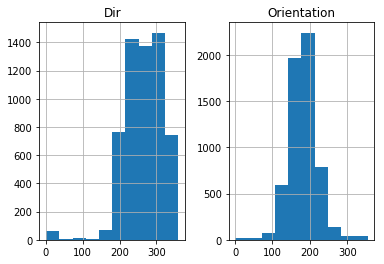

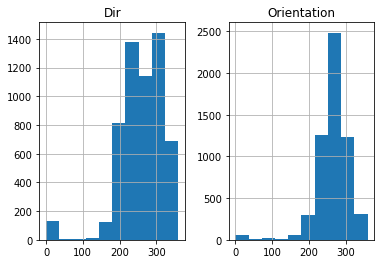

In [26]:
train[(train['IsBallCarrier'] == True) & (train['ToLeft'] ==True)].groupby('Season').hist(column=['Dir', 'Orientation'])
print(train[(train['IsBallCarrier'] == True) & (train['ToLeft'] ==True)].groupby('Season')['Dir', 'Orientation'].mean())

In [27]:
train[(train['Season'] == 2017) & (train['IsBallCarrier'] == True)][['Dir', 'Orientation']].head(11)

,Dir,Orientation
18,245.74,161.98
40,312.20,210.70
62,221.96,140.82
84,275.44,186.22
98,157.92,34.27
128,319.67,189.77
149,203.83,149.73
172,282.12,205.60
186,129.93,16.13
208,141.28,21.53


In [28]:
train[(train['Season'] == 2017) ][['Dir', 'Orientation']].head(11)
# train[(train['Season'] == 2018) ][['Dir', 'Orientation']].head(11)

,Dir,Orientation
0,177.18,81.99
1,198.70,27.61
2,202.73,3.01
3,105.64,359.77
4,164.31,12.63
5,95.01,308.34
6,322.59,357.23
7,270.04,328.52
8,55.31,344.70
9,190.84,75.47


## Feature Cleaning
### 2017 Orientation shift 90 degree

In [29]:
# from https://www.kaggle.com/peterhurford/something-is-the-matter-with-orientation
def func_fix_Orientation_17():
    train.loc[train['Season'] == 2017, 'Orientation'] = np.mod(90 + train.loc[train['Season'] == 2017, 'Orientation'], 360)

func_fix_Orientation_17()
train[(train['Season'] == 2017) ][['Dir', 'Orientation']].head(11)

,Dir,Orientation
0,177.18,171.99
1,198.70,117.61
2,202.73,93.01
3,105.64,89.77
4,164.31,102.63
5,95.01,38.34
6,322.59,87.23
7,270.04,58.52
8,55.31,74.70
9,190.84,165.47


Season
2017    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
2018    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
dtype: object

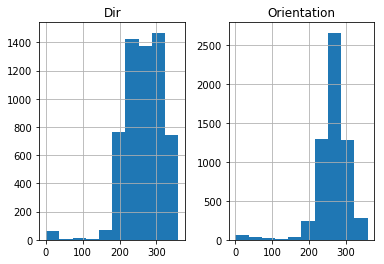

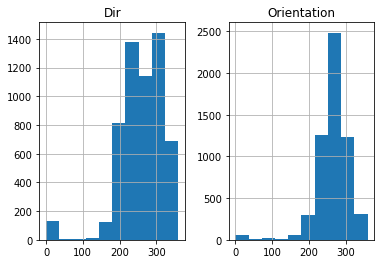

In [30]:
train[(train['IsBallCarrier'] == True) & (train['ToLeft'] ==True)].groupby('Season').hist(column=['Dir', 'Orientation'])

In [31]:
train[(train['Season'] == 2017) & (train['IsBallCarrier'] == True)][['Dir', 'Orientation']].head(11)

,Dir,Orientation
18,245.74,251.98
40,312.20,300.70
62,221.96,230.82
84,275.44,276.22
98,157.92,124.27
128,319.67,279.77
149,203.83,239.73
172,282.12,295.60
186,129.93,106.13
208,141.28,111.53


In [32]:
train.head(3)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,StadiumType,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,ToLeft,Dir_rad,IsBallCarrier,NaturalGrass,PlayerAge,TimeBetween_SnapHandoff,GameClock_seconds,PlayerBMI
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,171.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,72,212,SS,NE,KC,1,Gillette Stadium,1.0,Clear and warm,63.0,77.0,8,SW,True,4.761607,False,0,28.7,1.0,854,28.749228
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,117.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,75,288,DE,NE,KC,1,Gillette Stadium,1.0,Clear and warm,63.0,77.0,8,SW,True,4.386012,False,0,28.5,1.0,854,35.993600
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,93.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,75,270,DE,NE,KC,1,Gillette Stadium,1.0,Clear and warm,63.0,77.0,8,SW,True,4.315676,False,0,28.6,1.0,854,33.744000


## Feature engineering
### Standardizationo of X,Y

In [33]:
train['TeamOnOffense'] = "home"
train.loc[train.PossessionTeam != train.HomeTeamAbbr, 'TeamOnOffense'] = "away"
train['IsOnOffense'] = train.Team == train.TeamOnOffense # Is player on offense?
train['YardLine_std'] = 100 - train.YardLine
train.loc[train.FieldPosition.fillna('') == train.PossessionTeam,  
          'YardLine_std'
         ] = train.loc[train.FieldPosition.fillna('') == train.PossessionTeam,  
          'YardLine']
train['X_std'] = train.X
train.loc[train.ToLeft, 'X_std'] = 120 - train.loc[train.ToLeft, 'X'] 
train['Y_std'] = train.Y
train.loc[train.ToLeft, 'Y_std'] = 160/3 - train.loc[train.ToLeft, 'Y'] 
train['Dir_std'] = train.Dir_rad
train.loc[train.ToLeft, 'Dir_std'] = np.mod(np.pi + train.loc[train.ToLeft, 'Dir_rad'], 2*np.pi)
# train['Orientation_std'] = train.Orientation_rad
# train.loc[train.ToLeft, 'Orientation_std'] = np.mod(np.pi + train.loc[train.ToLeft, 'Orientation_rad'], 2*np.pi)

In [34]:
train[train.GameId == 2017090700].PlayId.unique()

array([20170907000118, 20170907000139, 20170907000189, 20170907000345,
       20170907000395, 20170907000473, 20170907000516, 20170907000653,
       20170907000680, 20170907000801, 20170907000917, 20170907001004,
       20170907001077, 20170907001156, 20170907001177, 20170907001296,
       20170907001355, 20170907001376, 20170907001443, 20170907001488,
       20170907001509, 20170907001530, 20170907001551, 20170907001605,
       20170907001664, 20170907001715, 20170907001736, 20170907001819,
       20170907001955, 20170907002430, 20170907002648, 20170907002669,
       20170907002829, 20170907002900, 20170907002961, 20170907003138,
       20170907003161, 20170907003261, 20170907003444, 20170907003465,
       20170907003507, 20170907003635, 20170907003874, 20170907004025,
       20170907004046, 20170907004182, 20170907004314, 20170907004465,
       20170907004486, 20170907004622, 20170907004660, 20170907004721])

In [35]:
def show_play_std(play_id, train=train):
    df = train[train.PlayId == play_id]
    YardLine = df.YardLine_std.values[0]
    fig, ax = create_football_field(highlight_line=True,highlight_line_number=YardLine)
    ax.scatter(df.X_std, df.Y_std, cmap='rainbow', c=~df.IsOnOffense, s=30)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X_std, rusher_row.Y_std, color='black', s=30)
    yards_covered = rusher_row["Yards"].values[0]

    for (x, y, Dir, S) in zip(df.X_std, df.Y_std, df.Dir_std, df.S):       
        dx, dy = get_dx_dy(Dir, S)
        ax.arrow(x, y, dx, dy, length_includes_head=False, width=0.2, color='black', alpha=0.5)
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}, scrimage is {YardLine} ', fontsize=20)
    plt.legend()
    plt.show()

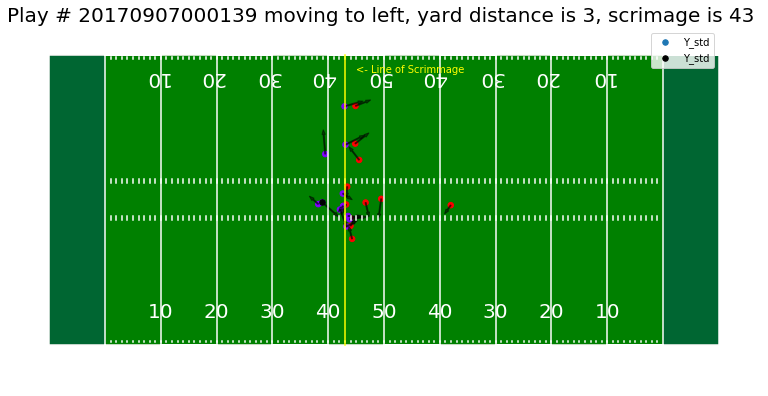

In [36]:
show_play_std(20170907000139)


In [37]:
train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,StadiumType,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,ToLeft,Dir_rad,IsBallCarrier,NaturalGrass,PlayerAge,TimeBetween_SnapHandoff,GameClock_seconds,PlayerBMI,TeamOnOffense,IsOnOffense,YardLine_std,X_std,Y_std,Dir_std
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,171.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,72,212,SS,NE,KC,1,Gillette Stadium,1.0,Clear and warm,63.0,77.0,8,SW,True,4.761607,False,0,28.7,1.0,854,28.749228,home,False,35,46.09,18.493333,1.620015
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,117.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,75,288,DE,NE,KC,1,Gillette Stadium,1.0,Clear and warm,63.0,77.0,8,SW,True,4.386012,False,0,28.5,1.0,854,35.993600,home,False,35,45.33,20.693333,1.244420
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,93.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,75,270,DE,NE,KC,1,Gillette Stadium,1.0,Clear and warm,63.0,77.0,8,SW,True,4.315676,False,0,28.6,1.0,854,33.744000,home,False,35,46.00,20.133333,1.174083
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,89.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,75,245,ILB,NE,KC,1,Gillette Stadium,1.0,Clear and warm,63.0,77.0,8,SW,True,6.010216,False,0,34.8,1.0,854,30.619556,home,False,35,48.54,25.633333,2.868623
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,102.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06,2017-09-08 00:44:05,8,72,206,FS,NE,KC,1,Gillette Stadium,1.0,Clear and warm,63.0,77.0,8,SW,True,4.986231,False,0,30.1,1.0,854,27.935571,home,False,35,50.68,17.913333,1.844638


In [39]:
position_abb_key_list = train.Position.unique().tolist()
position_abb_value_list = ['strong safety', 'defensive end', 'inside linebacker','free safety','corner back','defensive tackle',\
                           'wide receiver', 'tight end', 'tackle', 'quarter back', 'running back',\
                          'guard','center','outside linebacker', 'nose tackle', 'full back', 'middle linebacker','linebacker',\
                           'offensive tackle', 'offensive guard','half back','defensive back', 'safety', 'defensive lineman', 'safety']

player_position_dict = dict(zip(position_abb_key_list, position_abb_value_list))

In [40]:
# Defence
# 1st row (defencive line or DL) : DE, DT, NT, DL
# 2nd row(linebacker or LB) : ILB, OLB, MLB, LB
# 3rd row(Defensive Backs or DB) : SS, FS, S, SAF, CB,

# Offence Personnel : WR, TE, RB
player_position_dict

{'SS': 'strong safety',
 'DE': 'defensive end',
 'ILB': 'inside linebacker',
 'FS': 'free safety',
 'CB': 'corner back',
 'DT': 'defensive tackle',
 'WR': 'wide receiver',
 'TE': 'tight end',
 'T': 'tackle',
 'QB': 'quarter back',
 'RB': 'running back',
 'G': 'guard',
 'C': 'center',
 'OLB': 'outside linebacker',
 'NT': 'nose tackle',
 'FB': 'full back',
 'MLB': 'middle linebacker',
 'LB': 'linebacker',
 'OT': 'offensive tackle',
 'OG': 'offensive guard',
 'HB': 'half back',
 'DB': 'defensive back',
 'S': 'safety',
 'DL': 'defensive lineman',
 'SAF': 'safety'}

In [41]:

show_list = ['X','Y', 'S','A', 'Dis', "Orientation", 'Dir', 'DisplayName', 'OffensePersonnel',\
             'DefendersInTheBox', 'DefensePersonnel', 'Position','X_std', 'Y_std', 'Dir_std', 'IsOnOffense', 'IsBallCarrier']
train[train.PlayId == 20170910001102][show_list][0:11]

,X,Y,S,A,Dis,Orientation,Dir,DisplayName,OffensePersonnel,DefendersInTheBox,DefensePersonnel,Position,X_std,Y_std,Dir_std,IsOnOffense,IsBallCarrier
1386,96.47,40.86,1.37,1.06,0.22,263.79,85.80,Buster Skrine,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 2 LB, 5 DB",CB,96.47,40.86,0.073304,False,False
1387,88.28,30.73,3.03,1.97,0.29,269.58,0.14,Muhammad Wilkerson,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 2 LB, 5 DB",DE,88.28,30.73,1.568353,False,False
1388,89.01,27.64,2.75,0.59,0.33,267.95,11.74,Steve McLendon,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 2 LB, 5 DB",NT,89.01,27.64,1.365895,False,False
1389,90.50,28.87,0.98,0.13,0.08,258.82,317.59,Demario Davis,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 2 LB, 5 DB",ILB,90.50,28.87,2.310990,False,False
1390,92.88,14.94,2.86,2.24,0.31,353.53,144.46,Morris Claiborne,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 2 LB, 5 DB",CB,92.88,14.94,5.332679,False,False
1391,90.85,26.30,1.40,0.97,0.08,280.71,341.48,Julian Stanford,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 2 LB, 5 DB",ILB,90.85,26.30,1.894031,False,False
1392,87.83,20.82,2.80,2.25,0.26,301.69,351.28,Kony Ealy,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 2 LB, 5 DB",DE,87.83,20.82,1.722989,False,False
1393,105.78,28.55,1.41,0.47,0.18,261.39,79.43,Terrence Brooks,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 2 LB, 5 DB",SS,105.78,28.55,0.184481,False,False
1394,86.89,24.65,3.19,0.42,0.39,336.64,328.86,Leonard Williams,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 2 LB, 5 DB",DE,86.89,24.65,2.114292,False,False
1395,90.98,23.21,2.21,1.76,0.20,291.76,330.83,Jamal Adams,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 2 LB, 5 DB",SS,90.98,23.21,2.079909,False,False


### Thought_1
- DisplayName is duplicated info to NflId
- [Done] JerseyNumber, PlayerCollegeName are irrelevant to machine
- [Done] Location can be dupliated info to Stadium
- [Done] Feature transformation: Age using PlayerBirthDate 
- [Done] Feature transformation : TimeDifference_SnapHandoff = TimeHandoff - TimeSnap
- StadiumType should be onehotencoded

### Thought_2
- From Big Data Bowl - Comprehensive EDA with Pandas (https://www.kaggle.com/robikscube/big-data-bowl-comprehensive-eda-with-pandas)
    - Defender in the box vs Yards
    - DL-LB combo vs Yards

In [ ]:
oneUniqueList=[]
nonUniqueList=[]

for column in mini_train1.columns:
    if len(mini_train1[column].unique()) == 1:
        oneUniqueList.append(column)
    else:
         nonUniqueList.append((column, len(mini_train1[column].unique())))    

In [ ]:
for i in nonUniqueList:
    print(i)

In [ ]:
position_abb_key_list = train.Position.unique().tolist()
position_abb_value_list = ['strong safety', 'defensive end', 'inside linebacker','free safety','corner back','defensive tackle',\
                           'wide receiver', 'tight end', 'tackle', 'quarter back', 'running back',\
                          'guard','center','outside linebacker', 'nose tackle', 'full back', 'middle linebacker','linebacker',\
                           'offensive tackle', 'offensive guard','half back','defensive back', 'safety', 'defensive lineman', 'safety']


In [ ]:
player_position_dict = dict(zip(position_abb_key_list, position_abb_value_list))
player_position_dict

In [64]:
tmp_list = train['DefensePersonnel'].unique().tolist()
tmp_list
# train[(train['DefensePersonnel']=='4 DL, 5 LB, 1 DB, 1 OL')]
train[(train['DefensePersonnel']=='2 DL, 4 LB, 4 DB, 1 OL')][11:22]

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,StadiumType,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,ToLeft,Dir_rad,IsBallCarrier,NaturalGrass,PlayerAge,TimeBetween_SnapHandoff,GameClock_seconds,PlayerBMI,TeamOnOffense,IsOnOffense,YardLine_std,X_std,Y_std,Dir_std
49709,2017100101,20171001012698,home,79.38,29.96,1.21,1.06,0.16,248.37,174.47,2507865,Ben Garland,63,2017,31,3,02:19:00,BUF,1,10,ATL,10,14,79607,I_FORM,"2 RB, 2 TE, 1 WR",6.0,"2 DL, 4 LB, 4 DB, 1 OL",right,2017-10-01 19:03:04,2017-10-01 19:03:03,4,77,308,G,ATL,BUF,4,Mercedes-Benz Stadium,0.0,NaN,NaN,0.0,NaN,NaN,False,4.808906,False,0,29.5,1.0,139,36.519481,away,False,69,79.38,29.96,4.808906
49710,2017100101,20171001012698,home,79.88,30.93,2.32,1.04,0.28,224.24,168.82,2532989,Derrick Shelby,90,2017,31,3,02:19:00,BUF,1,10,ATL,10,14,79607,I_FORM,"2 RB, 2 TE, 1 WR",6.0,"2 DL, 4 LB, 4 DB, 1 OL",right,2017-10-01 19:03:04,2017-10-01 19:03:03,4,74,280,DE,ATL,BUF,4,Mercedes-Benz Stadium,0.0,NaN,NaN,0.0,NaN,NaN,False,4.907517,False,0,28.6,1.0,139,35.945946,away,False,69,79.88,30.93,4.907517
49711,2017100101,20171001012698,home,79.97,28.26,0.68,0.67,0.20,231.90,83.10,2533435,Dontari Poe,92,2017,31,3,02:19:00,BUF,1,10,ATL,10,14,79607,I_FORM,"2 RB, 2 TE, 1 WR",6.0,"2 DL, 4 LB, 4 DB, 1 OL",right,2017-10-01 19:03:04,2017-10-01 19:03:03,4,75,346,NT,ATL,BUF,4,Mercedes-Benz Stadium,0.0,NaN,NaN,0.0,NaN,NaN,False,0.120428,False,0,27.1,1.0,139,43.242311,away,False,69,79.97,28.26,0.120428
49712,2017100101,20171001012698,home,77.14,23.28,2.56,1.94,0.35,307.35,284.31,2539334,Desmond Trufant,21,2017,31,3,02:19:00,BUF,1,10,ATL,10,14,79607,I_FORM,"2 RB, 2 TE, 1 WR",6.0,"2 DL, 4 LB, 4 DB, 1 OL",right,2017-10-01 19:03:04,2017-10-01 19:03:03,4,72,190,CB,ATL,BUF,4,Mercedes-Benz Stadium,0.0,NaN,NaN,0.0,NaN,NaN,False,2.891836,False,0,27.1,1.0,139,25.765818,away,False,69,77.14,23.28,2.891836
49713,2017100101,20171001012698,home,84.38,42.04,2.99,1.75,0.32,195.80,112.07,2539653,Robert Alford,23,2017,31,3,02:19:00,BUF,1,10,ATL,10,14,79607,I_FORM,"2 RB, 2 TE, 1 WR",6.0,"2 DL, 4 LB, 4 DB, 1 OL",right,2017-10-01 19:03:04,2017-10-01 19:03:03,4,70,186,CB,ATL,BUF,4,Mercedes-Benz Stadium,0.0,NaN,NaN,0.0,NaN,NaN,False,5.897991,False,0,28.9,1.0,139,26.685306,away,False,69,84.38,42.04,5.897991
49714,2017100101,20171001012698,home,82.38,28.59,2.28,1.61,0.28,254.08,184.26,2555162,Deion Jones,45,2017,31,3,02:19:00,BUF,1,10,ATL,10,14,79607,I_FORM,"2 RB, 2 TE, 1 WR",6.0,"2 DL, 4 LB, 4 DB, 1 OL",right,2017-10-01 19:03:04,2017-10-01 19:03:03,4,73,227,MLB,ATL,BUF,4,Mercedes-Benz Stadium,0.0,NaN,NaN,0.0,NaN,NaN,False,4.638038,False,0,22.9,1.0,139,29.945768,away,False,69,82.38,28.59,4.638038
49715,2017100101,20171001012698,home,79.25,33.57,2.29,1.07,0.25,212.70,185.13,2555255,De'Vondre Campbell,59,2017,31,3,02:19:00,BUF,1,10,ATL,10,14,79607,I_FORM,"2 RB, 2 TE, 1 WR",6.0,"2 DL, 4 LB, 4 DB, 1 OL",right,2017-10-01 19:03:04,2017-10-01 19:03:03,4,75,232,OLB,ATL,BUF,4,Mercedes-Benz Stadium,0.0,NaN,NaN,0.0,NaN,NaN,False,4.622854,False,0,24.3,1.0,139,28.994844,away,False,69,79.25,33.57,4.622854
49716,2017100101,20171001012698,home,86.65,23.87,0.84,1.28,0.04,285.12,255.66,2555543,Keanu Neal,22,2017,31,3,02:19:00,BUF,1,10,ATL,10,14,79607,I_FORM,"2 RB, 2 TE, 1 WR",6.0,"2 DL, 4 LB, 4 DB, 1 OL",right,2017-10-01 19:03:04,2017-10-01 19:03:03,4,72,211,FS,ATL,BUF,4,Mercedes-Benz Stadium,0.0,NaN,NaN,0.0,NaN,NaN,False,3.391873,False,0,22.2,1.0,139,28.613619,away,False,69,86.65,23.87,3.391873
49717,2017100101,20171001012698,home,79.83,26.66,1.64,1.83,0.21,265.27,50.53,2557872,Takkarist McKinley,98,2017,31,3,02:19:00,BUF,1,10,ATL,10,14,79607,I_FORM,"2 RB, 2 TE, 1 WR",6.0,"2 DL, 4 LB, 4

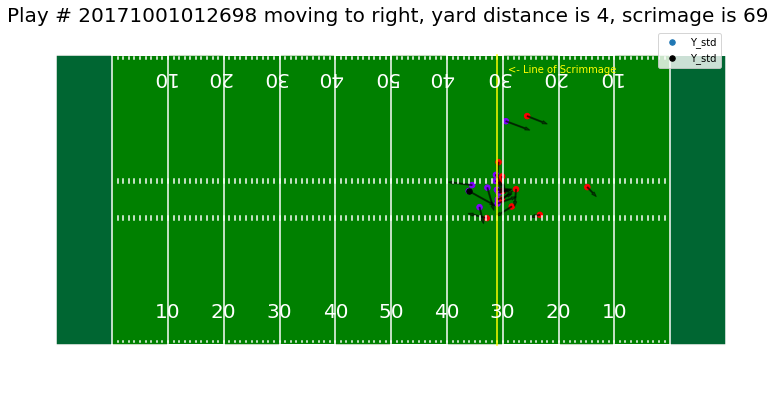

In [65]:
show_play_std(20171001012698)


Columns

Each row in the file corresponds to a single player's involvement in a single play. The dataset was intentionally joined (i.e. denormalized) to make the API simple. All the columns are contained in one large dataframe which is grouped and provided by PlayId.

- GameId - a unique game identifier
- PlayId - a unique play identifier
- Team - home or away
- X - player position along the long axis of the field. See figure below.
- Y - player position along the short axis of the field. See figure below.
- S - speed in yards/second
- A - acceleration in yards/second^2
- Dis - distance traveled from prior time point, in yards
    -  Dis measures time covered in the most recent window of player tracking data. Given that tracking data roughly covers 10 frames per second, Dis corresponds to distance traveled in the recent 0.1 seconds. Note that speed and acceleration are directly calculated using Dis (this is done in the data pre-processing)
- Orientation - orientation of player (deg)
- Dir - angle of player motion (deg)
- NflId - a unique identifier of the player
- DisplayName - player's name
- JerseyNumber - jersey number
- Season - year of the season
- YardLine - the yard line of the line of scrimmage
- Quarter - game quarter (1-5, 5 == overtime)
- GameClock - time on the game clock
- PossessionTeam - team with possession
- Down - the down (1-4)
- Distance - yards needed for a first down
- FieldPosition - which side of the field the play is happening on
- HomeScoreBeforePlay - home team score before play started
- VisitorScoreBeforePlay - visitor team score before play started
- NflIdRusher - the NflId of the rushing player
- OffenseFormation - offense formation
- OffensePersonnel - offensive team positional grouping
- DefendersInTheBox - number of defenders lined up near the line of scrimmage, spanning the width of the offensive line
- DefensePersonnel - defensive team positional grouping
- PlayDirection - direction the play is headed
- TimeHandoff - UTC time of the handoff
- TimeSnap - UTC time of the snap
- Yards - the yardage gained on the play (you are predicting this)
- PlayerHeight - player height (ft-in)
- PlayerWeight - player weight (lbs)
- PlayerBirthDate - birth date (mm/dd/yyyy)
- PlayerCollegeName - where the player attended college
- Position - the player's position (the specific role on the field that they typically play)
- HomeTeamAbbr - home team abbreviation
- VisitorTeamAbbr - visitor team abbreviation
- Week - week into the season
- Stadium - stadium where the game is being played
- Location - city where the game is being player
- StadiumType - description of the stadium environment
- Turf - description of the field surface
- GameWeather - description of the game weather
- Temperature - temperature (deg F)
- Humidity - humidity
- WindSpeed - wind speed in miles/hour
- WindDirection - wind direction

https://www.kaggle.com/c/nfl-big-data-bowl-2020/data